# DSCI 100: Final Project
# Using Session Times to Forecast Peak Gaming Hours, Days, and Months

## Introduction
This report analyzes data collected by a research group in Computer Science at UBC led by Frank Wood. The data collected is with regard to how people play video games, which is done by setting up a MineCraft server. This server records players actions as they navigate through the world. In order to run the project successfully, the researchers must understand how they should target their recruitment efforts and whether they have enough resources. This report will in particular be interested in analyzing the time windows that are most likely to have the largest number of simultaneous players in order to accommodate the large number of simultaneous players adequately. More specifically, the report will answer whether session start and end times can be used to accurately predict peak gaming hours in the day, peak days of the week, and peak months of the year. 

This will be completed by utilizing the data supplied by the sessions.csv dataset, which includes a list of individual play sessions by each player, including data about the session. 

### Details about sessions.csv
- **Number of observations**: 1535 player sessions
- **Number of variables**: 5
- **Information about variables:**


| Variable              | Type    | Description |
|----------------------|--------|-------------|
| `hashedEmail`        | String | Unique identifier of player |
| `start_time`         | String | Start time of the session |
| `end_time`           | String | End time of the session |
| `original_start_time`| Numeric | Unix timestamp of `start_time` |
| `original_end_time`  | Numeric | Unix timestamp of `end_time` |


## Methods and Results
describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
your report should include code which:
loads data 
wrangles and cleans the data to the format necessary for the planned analysis
performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
performs the data analysis
creates a visualization of the analysis 
note: all figures should have a figure number and a legend

### Data Loading and Wrangling

In [16]:
# Load necessary libraries
library(ggplot2)
library(tidyverse)
library(tidymodels)

# Load datasets
sessions <- read_csv("sessions.csv")

sessions <- sessions %>%
  mutate(original_start_time = as.numeric(original_start_time),
         original_end_time = as.numeric(original_end_time))

if (max(sessions$original_start_time, na.rm = TRUE) > 1e10) {
  sessions <- sessions %>%
    mutate(original_start_time = original_start_time / 1000,
           original_end_time = original_end_time / 1000)
}


sessions <- sessions %>%
  mutate(
    start_time = as_datetime(original_start_time, tz = "UTC"),
    end_time = as_datetime(original_end_time, tz = "UTC")
  )


sessions <- sessions |>
  mutate(
    start_time = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M"),
    end_time = as.POSIXct(end_time, format = "%d/%m/%Y %H:%M"),
    original_start_time = as.POSIXct(original_start_time, format = "%d/%m/%Y %H:%M"),
    original_end_time = as.POSIXct(original_end_time, format = "%d/%m/%Y %H:%M"),
  )

head(sessions)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<dttm>,<dttm>,<dttm>,<dttm>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 17:53:20,2024-06-30 17:53:20,2024-06-30 17:53:20,2024-06-30 17:53:20
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-18 00:20:00,2024-06-18 00:20:00,2024-06-18 00:20:00,2024-06-18 00:20:00
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:53:20,2024-07-25 17:53:20,2024-07-25 17:53:20,2024-07-25 17:53:20
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 04:00:00,2024-07-25 04:00:00,2024-07-25 04:00:00,2024-07-25 04:00:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 15:13:20,2024-05-25 15:13:20,2024-05-25 15:13:20,2024-05-25 15:13:20
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-23 16:26:40,2024-06-23 16:26:40,2024-06-23 16:26:40,2024-06-23 16:26:40


### Summary of dataset

In [17]:
## analysis of averages etc from sessions dataset

### Visualizations of Dataset

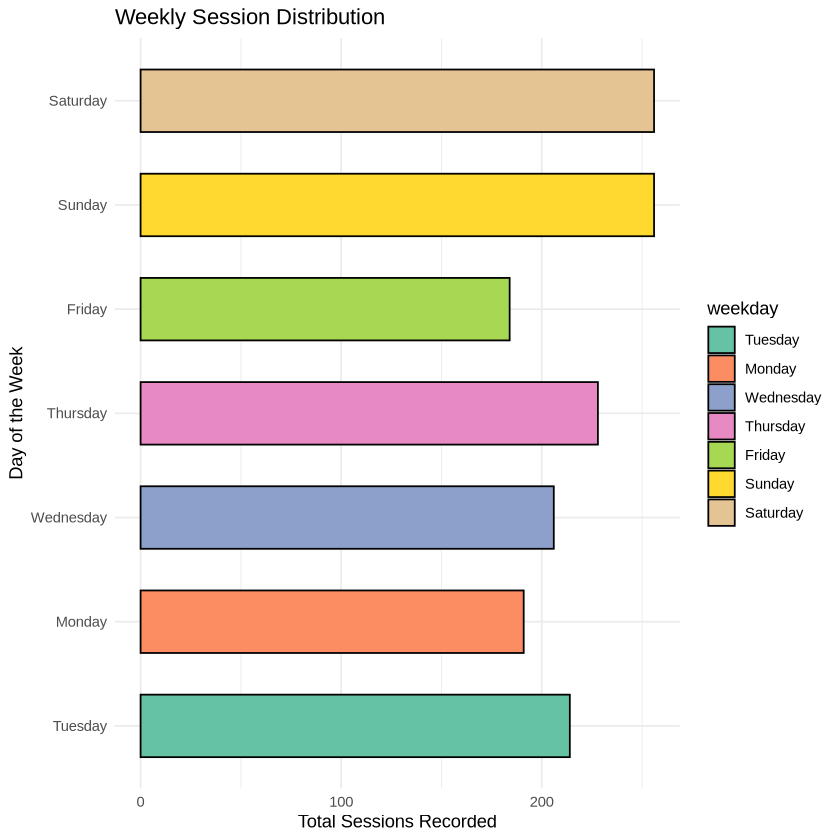

In [18]:
#group by week
weekday_players <- sessions |>
    mutate(weekday = factor(format(start_time, "%A"), 
                            levels = c("Tuesday", "Monday", "Wednesday", "Thursday", 
                                       "Friday", "Sunday", "Saturday"))) |>
    group_by(weekday) |>
    summarise(player_count = n())

weekday_plot <- ggplot(weekday_players, aes(x = weekday, y = player_count, fill = weekday)) +
    geom_bar(stat = "identity", width = 0.6, color = "black") +
    scale_fill_brewer(palette = "Set2") + 
    labs(title = "Weekly Session Distribution", 
         x = "Day of the Week", 
         y = "Total Sessions Recorded") +
    theme_minimal() +
    coord_flip()
weekday_plot


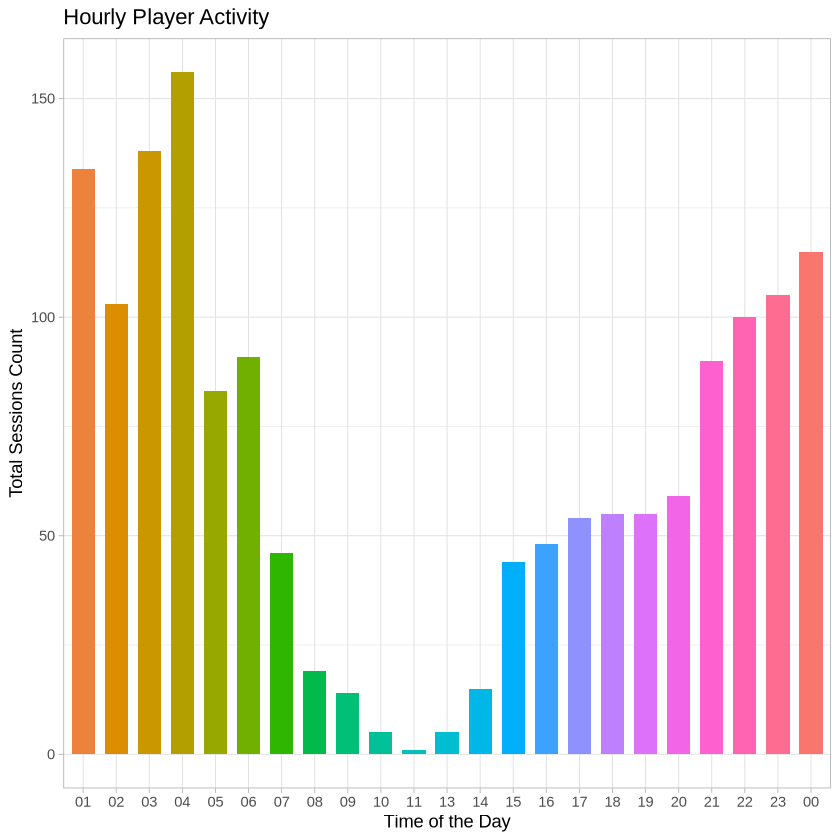

In [19]:
#group by hour
hourly_players <- sessions |>
    mutate(hour = format(start_time, "%H")) |>
    group_by(hour) |>
    summarise(player_count = n())

hour_plot <- ggplot(hourly_players, aes(x = factor(hour, levels = sprintf("%02d", c(1:23, 0))), 
                                        y = player_count, fill = hour)) +
    geom_bar(stat = "identity", width = 0.7, show.legend = FALSE) + 
    labs(title = "Hourly Player Activity", 
         x = "Time of the Day", 
         y = "Total Sessions Count") +
    theme_light()

hour_plot

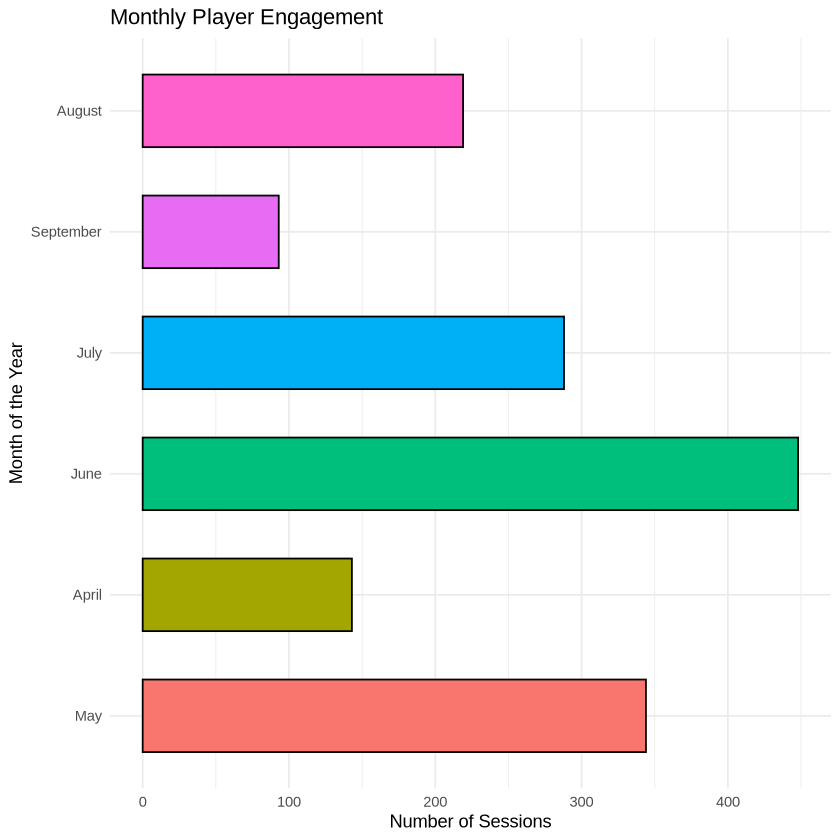

In [20]:
monthly_players <- sessions |>
    mutate(month = factor(format(start_time, "%B"), 
                          levels = c("March", "January", "February", "May", "April", "June",
                                     "July", "September", "August", "October", "December", "November"))) |>
    group_by(month) |>
    summarise(player_count = n())

month_plot <- ggplot(monthly_players, aes(x = month, y = player_count, fill = month)) +
    geom_bar(stat = "identity", width = 0.6, color = "black", show.legend = FALSE) +
    scale_fill_manual(values = c("#F8766D", "#A3A500", "#00BF7D", "#00B0F6", "#E76BF3", "#FF61CC", 
                                 "#D89000", "#39B600", "#00BFC4", "#9590FF", "#C77CFF", "#7CAE00")) + 
    labs(title = "Monthly Player Engagement", 
         x = "Month of the Year", 
         y = "Number of Sessions") +
    theme_minimal() +
    coord_flip()
month_plot

**Insights from Visualizations:**
- **Peak hours occur late at night**, with the highest activity observed around **4 AM**. This suggests that the majority of players are active during nighttime, possibly due to time zone differences or gaming habits.  
- **Weekends see the highest number of sessions**, indicating that players are more likely to engage in gaming during their free time. This trend aligns with typical recreational behavior.  
- **Certain months have missing data**, making it essential to interpret seasonal trends cautiously. However, based on the available records, **June exhibits the highest activity, followed by May**. This pattern could be influenced by academic schedules, holidays, or seasonal gaming trends.  


### KNN Analysis
This report aims to forecast player demand by predicting the number of concurrent players on the server at any given time. Through exploratory data analysis, we identified that **peak activity occurs around 4 AM**, **weekends see the highest engagement**, and **June has the highest recorded sessions** among the available data. 

To achieve accurate demand forecasting, we propose using the **K-Nearest Neighbors (KNN) model**, which leverages historical time-windowed player activity to predict future trends. This method is well-suited for structured datasets and effectively captures recurring gaming patterns. 

While KNN is a robust approach, **outliers, missing data, and seasonal variations** present challenges that must be accounted for. To mitigate these limitations, **cross-validation and RMSPE evaluation** will be used to optimize model performance and ensure reliability. 

By accurately forecasting player demand, this study can help **optimize resource allocation, server stability, and recruitment strategies**, ultimately improving the overall player experience. Future work could explore additional predictive methods, such as time-series models, to enhance forecasting precision.

In [21]:
# CHANGE TO FOR SESSIONS
player_model_data <- players |>
  select(subscribe, Age, gender, experience, played_hours) |>
  filter(!is.na(Age)) |>
    mutate(subscribe = as.factor(subscribe))

player_split <- initial_split(player_model_data, prop = 0.75, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)
player_recipe <- recipe(subscribe ~ Age + gender + experience + played_hours, data = player_train) |>
  step_dummy(all_nominal_predictors()) |>
  step_normalize(all_predictors())

player_recipe <- recipe(subscribe ~ Age + gender + experience + played_hours, data = player_train) |>
  step_dummy(all_nominal_predictors()) |>
  step_normalize(all_predictors())

# 4. Define KNN model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")

# 5. Combine recipe and model into a workflow
player_workflow <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_spec)

# 6. Fit the model
player_fit <- fit(player_workflow, data = player_train)

# 7. Predict on test data
player_predictions <- predict(player_fit, player_test) |>
  bind_cols(player_test)

# 8. Evaluate model
player_accuracy <- player_predictions |>
  metrics(truth = subscribe, estimate = .pred_class)

player_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7142857
kap,binary,0.1403509


## Discussion


---

## 🧰 Real-World Applications

| Insight | Potential Action |
|--------|------------------|
| ⏰ Peak play hours identified (e.g., 7–10 PM) | 🔧 Allocate more **server resources** during those times to reduce lag |
| 📅 Weekly or monthly engagement trends | 🗓️ **Schedule live events** or **patches** during high-traffic periods |
| 🎯 Predicting likely subscribers | ✉️ **Target email campaigns** or push notifications to likely-to-subscribe users |
| 📉 Identifying non-engaged users | 🧲 Offer **incentives or tutorials** to improve retention and conversion |
| 🛠️ Future player modeling | 🧠 Inform **churn prediction models** or **recommendation systems** |

By aligning technical insights with actionable strategies, such analysis can guide both **game development** and **business decisions**.
